<a href="https://colab.research.google.com/github/dassouvik123/MERN-Stack/blob/main/Modified_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/content/drive/MyDrive/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 15)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)}{class_name}')
            return images
        self.images={}
        self.class_names=['normal','viral','covid']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

In [ ]:
train_dirs = {
    'normal': '/content/drive/MyDrive/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/MyDrive/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/MyDrive/COVID-19 Radiography Database/covid'
}
train_dataset=ChestXRayDataset(train_dirs, train_transform)
#print(train_dirs)
#print(train_transform)


Found 1311normal
Found 1315viral
Found 189covid


In [ ]:
test_dirs = {
    'normal': '/content/drive/MyDrive/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/MyDrive/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/MyDrive/COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30normal
Found 30viral
Found 30covid


In [ ]:
batch_size=6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 470
Num of test batches 15


In [ ]:
class_names=train_dataset.class_names
def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1,6,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        mean=np.array([0.485,0.456,0.406])
        std= np.array([0.229, 0.224, 0.225])
        image=image*std/mean
        image=np.clip(image,0.,1.)
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

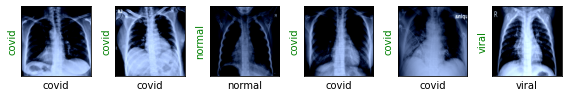

In [ ]:
images, labels =next(iter(dl_train))
show_images(images, labels, labels)


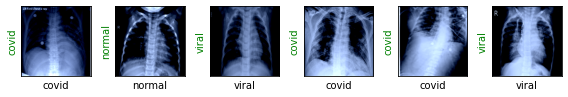

In [ ]:
images, labels =next(iter(dl_test))
show_images(images, labels, labels)

In [ ]:
resnet18 =torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc=torch.nn.Linear(in_features=512, out_features=3)
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels =next(iter(dl_test))
    outputs = resnet18(images)
    _, preds=torch.max(outputs, 1)
    show_images(images, labels, preds)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


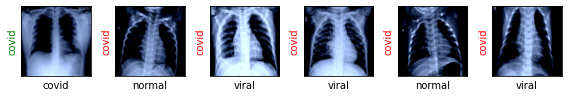

In [ ]:
show_preds()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        train_loss=0
        resnet18.train()
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs=resnet18(images)
            loss=loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss=loss.item()
            if train_step%20==0:
                print('Evaluating at step', train_step)
                acc=0.
                val_loss=0.
                resnet18.eval()
                for val_step,(images, labels) in enumerate(dl_test):
                    outputs=resnet18(images)
                    loss=loss_fn(outputs, labels)
                    val_loss+=loss.item()
                    _,preds=torch.max(outputs, 1)
                    acc+=sum(preds==labels).numpy()
                val_loss/=(val_step+1)
                acc=acc/len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                #show_preds()
                resnet18.train()
                
        train_loss/=(train_step+1)
        print(f'Training loss: {train_loss:.4f}')

In [ ]:
train(epochs=15)

Starting training..
Starting epoch 1/15
Evaluating at step 0
Val loss: 1.1470, Acc: 0.3444
Evaluating at step 20
Val loss: 0.4774, Acc: 0.9111
Evaluating at step 40
Val loss: 0.3504, Acc: 0.9111
Evaluating at step 60
Val loss: 0.2132, Acc: 0.9667
Evaluating at step 80
Val loss: 0.1790, Acc: 0.9444
Evaluating at step 100
Val loss: 0.1696, Acc: 0.9667
Evaluating at step 120
Val loss: 0.1318, Acc: 0.9778
Evaluating at step 140
Val loss: 0.0970, Acc: 0.9889
Evaluating at step 160
Val loss: 0.1123, Acc: 0.9889
Evaluating at step 180
Val loss: 0.1110, Acc: 0.9556
Evaluating at step 200
Val loss: 0.1665, Acc: 0.9444
Evaluating at step 220
Val loss: 0.1060, Acc: 0.9889
Evaluating at step 240
Val loss: 0.1056, Acc: 0.9667
Evaluating at step 260
Val loss: 0.0852, Acc: 0.9667
Evaluating at step 280
Val loss: 0.1211, Acc: 0.9667
Evaluating at step 300
Val loss: 0.0878, Acc: 1.0000
Evaluating at step 320
Val loss: 0.1400, Acc: 0.9222
Evaluating at step 340
Val loss: 0.1121, Acc: 0.9444
Evaluating a

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
#from .._internally_replaced_utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']





def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def Resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


In [ ]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

NameError: ignored

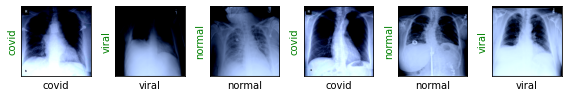

In [ ]:
show_preds()


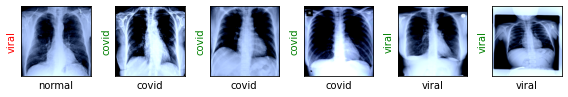

In [ ]:
show_preds()


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
torch.save(resnet18.state_dict(), '/content/drive/MyDrive/Model.py')

#resnet18 = TheModelClass(*args, **kwargs)
resnet18.load_state_dict(torch.load('/content/drive/MyDrive/Model.py'))
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dl_test:
      
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

In [ ]:
lbllist

In [ ]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

NameError: ignored

In [ ]:
import os, time, multiprocessing
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from glob import glob
#from data import get_celebA, flags
#from model import get_generator, get_discriminator

In [ ]:
pip install --upgrade tensorflow-gpu

In [ ]:
pip install --upgrade tensorflow

In [ ]:
>>> "1.9.0" < "1.6.0"
False
>>> "1.10.0" < "1.6.0"
True

True

In [ ]:
class FLAGS(object):
    def __init__(self):
        self.n_epoch = 25 # "Epoch to train [25]"
        self.z_dim = 100 # "Num of noise value]"
        self.lr = 0.0002 # "Learning rate of for adam [0.0002]")
        self.beta1 = 0.5 # "Momentum term of adam [0.5]")
        self.batch_size = 64 # "The number of batch images [64]")
        self.output_size = 64 # "The size of the output images to produce [64]")
        self.sample_size = 64 # "The number of sample images [64]")
        self.c_dim = 3 # "Number of image channels. [3]")
        self.save_every_epoch = 1 # "The interval of saveing checkpoints.")
        # self.dataset = "celebA" # "The name of dataset [celebA, mnist, lsun]")
        self.checkpoint_dir = "checkpoint" # "Directory name to save the checkpoints [checkpoint]")
        self.sample_dir = "samples" # "Directory name to save the image samples [samples]")
        assert np.sqrt(self.sample_size) % 1 == 0., 'Flag `sample_size` needs to be a perfect square'
flags = FLAGS()

tl.files.exists_or_mkdir(flags.checkpoint_dir) # save model
tl.files.exists_or_mkdir(flags.sample_dir) # save generated image

def get_celebA(output_size, n_epoch, batch_size):
    # dataset API and augmentation
    images_path = tl.files.load_file_list(path='data', regx='.*.jpg', keep_prefix=True, printable=False)
    def generator_train():
        for image_path in images_path:
            yield image_path.encode('utf-8')
    def _map_fn(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # get RGB with 0~1
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        # image = tf.image.crop_central(image, [FLAGS.output_size, FLAGS.output_size, FLAGS.c_dim])
        # image = tf.image.resize_images(image, FLAGS.output_size])
        image = image[45:173, 25:153, :] # central crop
        image = tf.image.resize([image], (output_size, output_size))[0]
        # image = tf.image.crop_and_resize(image, boxes=[[]], crop_size=[64, 64])
        # image = tf.image.resize_image_with_crop_or_pad(image, FLAGS.output_size, FLAGS.output_size) # central crop
        image = tf.image.random_flip_left_right(image)
        image = image * 2 - 1
        return image
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=tf.string)
    ds = train_ds.shuffle(buffer_size=4096)
    # ds = ds.shard(num_shards=hvd.size(), index=hvd.rank())
    # ds = ds.repeat(n_epoch)
    ds = ds.map(_map_fn, num_parallel_calls=4)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=2)
    return ds, images_path
    # for batch_images in train_ds:
    #     print(batch_images.shape)
    # value = ds.make_one_shot_iterator().get_next()

[TL] [*] creates checkpoint ...
[TL] [*] creates samples ...


In [ ]:
pip install tensorlayer

     |████████████████████████████████| 368kB 8.2MB/s 
     |████████████████████████████████| 3.3MB 35.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [ ]:
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import Input, Dense, DeConv2d, Reshape, BatchNorm2d, Conv2d, Flatten

def get_generator(shape, gf_dim=64): # Dimension of gen filters in first conv layer. [64]
    image_size = 64
    s16 = image_size // 16
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)

    ni = Input(shape)
    nn = Dense(n_units=(gf_dim * 8 * s16 * s16), W_init=w_init, b_init=None)(ni)
    nn = Reshape(shape=[-1, s16, s16, gf_dim*8])(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init, name=None)(nn)
    nn = DeConv2d(gf_dim * 4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d( decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim * 2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(3, (5, 5), (2, 2), act=tf.nn.tanh, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name='generator')

def get_discriminator(shape, df_dim=64): # Dimension of discrim filters in first conv layer. [64]
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x : tf.nn.leaky_relu(x, 0.2)

    ni = Input(shape)
    nn = Conv2d(df_dim, (5, 5), (2, 2), act=lrelu, W_init=w_init)(ni)
    nn = Conv2d(df_dim*2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*8, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Flatten()(nn)
    nn = Dense(n_units=1, act=tf.identity, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name='discriminator')
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import Input, Dense, DeConv2d, Reshape, BatchNorm2d, Conv2d, Flatten

def get_generator(shape, gf_dim=64): # Dimension of gen filters in first conv layer. [64]
    image_size = 64
    s16 = image_size // 16
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)

    ni = Input(shape)
    nn = Dense(n_units=(gf_dim * 8 * s16 * s16), W_init=w_init, b_init=None)(ni)
    nn = Reshape(shape=[-1, s16, s16, gf_dim*8])(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init, name=None)(nn)
    nn = DeConv2d(gf_dim * 4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d( decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim * 2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(3, (5, 5), (2, 2), act=tf.nn.tanh, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name='generator')

def get_discriminator(shape, df_dim=64): # Dimension of discrim filters in first conv layer. [64]
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x : tf.nn.leaky_relu(x, 0.2)

    ni = Input(shape)
    nn = Conv2d(df_dim, (5, 5), (2, 2), act=lrelu, W_init=w_init)(ni)
    nn = Conv2d(df_dim*2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*8, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Flatten()(nn)
    nn = Dense(n_units=1, act=tf.identity, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name='discriminator')

In [ ]:
import os, time, multiprocessing
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from glob import glob
#from data import get_celebA, flags
#from model import get_generator, get_discriminator

num_tiles = int(np.sqrt(flags.sample_size))

def train():
    images, images_path = get_celebA(flags.output_size, flags.n_epoch, flags.batch_size)
    G = get_generator([None, flags.z_dim])
    D = get_discriminator([None, flags.output_size, flags.output_size, flags.c_dim])

    G.train()
    D.train()

    d_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)
    g_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)

    n_step_epoch = int(len(images_path) // flags.batch_size)
    
    # Z = tf.distributions.Normal(0., 1.)
    for epoch in range(flags.n_epoch):
        for step, batch_images in enumerate(images):
            if batch_images.shape[0] != flags.batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape(persistent=True) as tape:
                # z = Z.sample([flags.batch_size, flags.z_dim]) 
                z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
                d_logits = D(G(z))
                d2_logits = D(batch_images)
                # discriminator: real images are labelled as 1
                d_loss_real = tl.cost.sigmoid_cross_entropy(d2_logits, tf.ones_like(d2_logits), name='dreal')
                # discriminator: images from generator (fake) are labelled as 0
                d_loss_fake = tl.cost.sigmoid_cross_entropy(d_logits, tf.zeros_like(d_logits), name='dfake')
                # combined loss for updating discriminator
                d_loss = d_loss_real + d_loss_fake
                # generator: try to fool discriminator to output 1
                g_loss = tl.cost.sigmoid_cross_entropy(d_logits, tf.ones_like(d_logits), name='gfake')

            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
            del tape

            print("Epoch: [{}/{}] [{}/{}] took: {:.3f}, d_loss: {:.5f}, g_loss: {:.5f}".format(epoch, \
                  flags.n_epoch, step, n_step_epoch, time.time()-step_time, d_loss, g_loss))
        
        if np.mod(epoch, flags.save_every_epoch) == 0:
            G.save_weights('{}/G.npz'.format(flags.checkpoint_dir), format='npz')
            D.save_weights('{}/D.npz'.format(flags.checkpoint_dir), format='npz')
            G.eval()
            result = G(z)
            G.train()
            tl.visualize.save_images(result.numpy(), [num_tiles, num_tiles], '{}/train_{:02d}.png'.format(flags.sample_dir, epoch))

if __name__ == '__main__':
    train()

FileNotFoundError: ignored

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorlayer as tl
## enable debug logging
tl.logging.set_verbosity(tl.logging.DEBUG)


def __init__(self):
  self.n_epoch = 25 # "Epoch to train [25]"
  self.z_dim = 100 # "Num of noise value]"
  self.lr = 0.0002 # "Learning rate of for adam [0.0002]")
  self.beta1 = 0.5 # "Momentum term of adam [0.5]")
  self.batch_size = 64 # "The number of batch images [64]")
  self.output_size = 64 # "The size of the output images to produce [64]")
  self.sample_size = 64 # "The number of sample images [64]")
  self.c_dim = 3 # "Number of image channels. [3]")
  self.save_every_epoch = 1 # "The interval of saveing checkpoints.")
  # self.dataset = "celebA" # "The name of dataset [celebA, mnist, lsun]")
  self.checkpoint_dir = "checkpoint" # "Directory name to save the checkpoints [checkpoint]")
  self.sample_dir = "samples" # "Directory name to save the image samples [samples]")
  assert np.sqrt(self.sample_size) % 1 == 0., 'Flag `sample_size` needs to be a perfect square'
flags = FLAGS()

tl.files.exists_or_mkdir(flags.checkpoint_dir) # save model
tl.files.exists_or_mkdir(flags.sample_dir) # save generated image

def get_celebA(output_size, n_epoch, batch_size):
    # dataset API and augmentation
    images_path = tl.files.load_file_list(path='data', regx='.*.jpg', keep_prefix=True, printable=False)
    def generator_train():
        for image_path in images_path:
            yield image_path.encode('utf-8')
    def _map_fn(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # get RGB with 0~1
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        # image = tf.image.crop_central(image, [FLAGS.output_size, FLAGS.output_size, FLAGS.c_dim])
        # image = tf.image.resize_images(image, FLAGS.output_size])
        image = image[45:173, 25:153, :] # central crop
        image = tf.image.resize([image], (output_size, output_size))[0]
        # image = tf.image.crop_and_resize(image, boxes=[[]], crop_size=[64, 64])
        # image = tf.image.resize_image_with_crop_or_pad(image, FLAGS.output_size, FLAGS.output_size) # central crop
        image = tf.image.random_flip_left_right(image)
        image = image * 2 - 1
        return image
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=tf.string)
    ds = train_ds.shuffle(buffer_size=4096)
    # ds = ds.shard(num_shards=hvd.size(), index=hvd.rank())
    # ds = ds.repeat(n_epoch)
    ds = ds.map(_map_fn, num_parallel_calls=4)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=2)
    return ds, images_path
    # for batch_images in train_ds:
    #     print(batch_images.shape)
    # value = ds.make_one_shot_iterator().get_next()

[TL] [!] checkpoint exists ...
[TL] [!] samples exists ...


In [ ]:
import os
import time
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

#from config import Config
from utils import adjust_data_range

def load_imgpaths(dir_path, split=False):

	files = os.listdir(dir_path)
	paths = [dir_path + file for file in files]
	random.shuffle(paths)
	if split:
		train_paths, eval_paths = \
		train_test_split(paths, test_size=0.05, random_state=Config.random_seed)
		return train_paths, eval_paths
	return paths

def load_and_preprocess(img_path):

    img_str = tf.io.read_file(img_path)
    img = tf.image.decode_and_crop_jpeg(img_str, Config.data_crop, channels=3)
    return img

def write_tfrecord(img_paths, tfrec_path):

	path_ds = tf.data.Dataset.from_tensor_slices(img_paths)
	image_ds = path_ds.map(load_and_preprocess, num_parallel_calls = Config.parallel_threads) 
	proto_ds = image_ds.map(tf.io.serialize_tensor)
	tfrec = tf.data.experimental.TFRecordWriter(tfrec_path)
	tfrec_op = tfrec.write(proto_ds)

def prepare_tfrecords():

	print("Preparing tfrecords")
	paths = load_imgpaths(Config.data_dir_path)
	if len(paths)==2:
		write_tfrecord(paths[0], Config.tfrecord_dir+'train.tfrecord')
		write_tfrecord(paths[1], Config.tfrecord_dir+'test.tfrecord')
	else:
		write_tfrecord(paths, Config.tfrecord_dir+'train.tfrecord')

def parse_fn(tfrecord):

	result_img = tf.io.parse_tensor(tfrecord, out_type=tf.uint8)
	result_img = tf.reshape(result_img, Config.img_shape)
	result_img = tf.cast(result_img, tf.float32)
	result_img = adjust_data_range(result_img, drange_in=[0,255], drange_out=[-1, 1])
	return result_img

def prepare_dataset(tfrecord_file):

	dataset = tf.data.TFRecordDataset(tfrecord_file)
	dataset = dataset.map(map_func=parse_fn, num_parallel_calls= Config.parallel_threads)
	#dataset = dataset.shuffle(buffer_size=Config.total_training_imgs, reshuffle_each_iteration=False)
	dataset = dataset.batch(batch_size=Config.global_batchsize, drop_remainder=True)
	dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
	return dataset

def main():
	start_time = time.time()
	prepare_tfrecords()
	end_time = time.time()
	print(end_time-start_time)
if __name__ == '__main__':
	main()

ModuleNotFoundError: ignored

In [ ]:
class Config:

	# dataset preparation config for CelebA dataset
	data_dir_path = 'CelebA/img_align_celeba/'
	tfrecord_dir = 'tfrecords/'  # dir where tfrecords are saved
	data_crop = [57, 21, 128, 128] # [crop-y(top-left y), crop-x(top-left x), crop-height, crop-width] (128 x 128 resolution images are taken)
	img_shape = (128, 128, 3) # image shape for Variational Autoencoder
	parallel_threads = 4   # number of parallel calls for writing and reading tfrecord (Depends on no.of cpu cores)

	# batch_norm layer parameters
	momentum = 0.9
	epsilon  = 1e-5

	# DCGAN architecture 
	latent_dim = 100
	disc_filters = [32, 64, 128, 256, 512]
	gen_filters  = [1024, 512, 256, 128, 64]

	#training parameters
	disc_lr = 0.0002  #learning rate of discriminator
	gen_lr = 0.0002   #learning rate of generator
	global_batchsize = 32   # Configure it based on available GPU memory
	total_training_imgs = 202599
	num_gpu = 2
	num_epochs = 30
	image_snapshot_freq = 1000  # Number of batches shown in between image_grid snapshots

	#Adam optimizer parameters
	beta1 = 0.5
	beta2 = 0.999

	random_seed = 42
	#results
	modelDir = 'model/'
	summaryDir = 'summaries/run4/'
	num_gen_imgs = 32   # number of images to generate
	grid_size = (4, 8)  # results are saved to an image grid of this size 
	results_dir = 'results/'

	#Generator is run twice for this run

In [ ]:
import glob
import numpy as np
from PIL import Image
#from config import Config

def adjust_data_range(data, drange_in, drange_out):

    if drange_in != drange_out:
        scale = (np.float32(drange_out[1]) - np.float32(drange_out[0])) / (np.float32(drange_in[1]) - np.float32(drange_in[0]))
        bias = (np.float32(drange_out[0]) - np.float32(drange_in[0]) * scale)
        data = data * scale + bias
    return data

def make_grid(images, grid_size=None):

	grid_h, grid_w = grid_size
	img_h, img_w = images.shape[1], images.shape[2]
	grid = np.zeros([grid_h*img_h, grid_w*img_w, 3], dtype=images.dtype)
	for idx in range(images.shape[0]):
		x = (idx % grid_w) * img_w
		y = (idx // grid_w) * img_h
		grid[y : y + img_h, x : x + img_w, :] = images[idx]
	return grid

def convert_to_pil_image(image, drange=[0,1]):

    assert image.ndim == 2 or image.ndim == 3
    if image.ndim == 3:
        if image.shape[2] == 1:
            image = image[2] # grayscale HWC => HW
    image = adjust_data_range(image, drange, [0,255])
    image = np.rint(image).clip(0, 255).astype(np.uint8)
    format = 'RGB' if image.ndim == 3 else 'L'
    return Image.fromarray(image, format)

def save_image(image, filename, drange=[0,1], quality=95):

    img = convert_to_pil_image(image, drange)
    if '.jpg' in filename:
        img.save(filename,"JPEG", quality=quality, optimize=True)
    else:
        img.save(filename)

def save_image_grid(images, filename, drange=[0,1], grid_size=None):

    save_image(make_grid(images, grid_size), filename, drange)

def make_training_gif():
    image_grids = []
    filenames = sorted(glob.glob(Config.results_dir+'fakes_*.jpg'))
    for file in filenames:
        epoch_num = int(file.split('_')[1][-2:])
        batch_num = int(file.split('_')[-1].split('.')[0][-5:])
        print(epoch_num)
        print(batch_num)
        if epoch_num< 2 or(epoch_num>2 and batch_num%4000==0):
            image = Image.open(file)
            image_grids.append(image)
    image_grids[0].save(Config.results_dir+'vae_training.gif', format='GIF', append_images=image_grids[1:], save_all=True, duration=500, loop=0)

def main():
    make_training_gif()

if __name__ == '__main__':
    main()

IndexError: ignored

In [ ]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = 2
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=1, is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_data_format() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=2 (input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=1 (block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

SyntaxError: ignored